## Project 2: Group 4 (Sevgi, Akbar and Andreas)

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# do not display the number with scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [2]:
path = 'eniac_data/'
orderlines = pd.read_csv(path + 'orderlines_cl.csv')
orders = pd.read_csv(path + 'orders_cl.csv')
brands = pd.read_csv(path + 'brands_cl.csv')
products = pd.read_csv(path + 'products_cl.csv')

In [3]:
orders['created_date'] = pd.to_datetime(orders['created_date'])
orderlines['date'] = pd.to_datetime(orderlines['date'])

In [4]:
import numpy as np
import re

### Part 1: Categories

##### Create df for calculating the price difference

In [5]:
p_df1 = (
orderlines
    .merge(orders, how='left', left_on='id_order', right_on='order_id')
    .query('state == "Completed"')
    .merge(products, how='left')
    .assign(price = lambda x: np.where(np.isnan(x['price']), x['max_price_orderlines'], x['price']))
    .assign(disc = lambda x: x['price'] - x['unit_price'],
           disc_perc = lambda x: round((1 - x['unit_price'] / x['price'])*100), 
           year_month = lambda x: x['date'].dt.to_period('M'))
    #.groupby(['year_month'])
   # .agg({'disc_perc':'mean'})
    #.reset_index()
)


##### Create df with categories

In [6]:
regexp_dict = {
    'wacom':'(wacom|Wacom)',
    'Macbook':'(Macbook|macbook)',
    'Ipad':'(IPad|iPad)',
    'iPhone':'(iPhone|IPhone)',
    'headset':'(headset|headphones|Headset)',
    'memory':'(memory)',
    'hard drive':'(hard drive|Hard drive)',
    'protect':'(protect|cover|sleeve|Screensaver|shell)',
    'watch':'(^.{0,6}apple watch|smartwatch|smart watch|Apple watch|Watch)',
    'monitor':'(Monitor|monitor)',
    'iMac':'(iMac|IMac)',
    'Mac mini':'Mac mini|mac mini',
    'USB':'USB',
    'Others':''
}

temp = products.copy().assign(category = 'unknown')


for val in regexp_dict.items(): 
    label = val[0]
    regexp = re.compile(val[1], flags=re.IGNORECASE)
    temp = (
    temp
        .assign(
            category = lambda x: np.where(
                (x['desc'].str.contains(regexp, regex=True)) &
                (x['category'] == 'unknown'), label, x['category'])))

temp['category'].value_counts()

C:\Users\godri\anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Others        2179
iPhone        2102
Ipad          1639
Macbook       1441
iMac           708
hard drive     687
USB            514
memory         370
watch          320
monitor        242
protect        198
Mac mini       128
headset         25
wacom           19
unknown          7
Name: category, dtype: int64

##### New dfs to relate the prices and discounts to the categories

In [7]:
products = products.merge(temp, how='left')

In [8]:
d = orderlines.merge(orders, how='left', left_on='id_order', right_on='order_id').query('state == "Completed"').merge(products, how='left').assign(price = lambda x: np.where(np.isnan(x['price']), x['max_price_orderlines'], x['price'])).assign(disc = lambda x: x['price'] - x['unit_price'],
disc_perc = lambda x: round((1 - x['unit_price'] / x['price'])*100), year_month = lambda x: x['date'].dt.to_period('M'))

In [9]:
e = d.groupby(['category']).agg({'product_quantity':'sum', 'total_price':'sum', 'disc':'mean', 'disc_perc':'mean'}).reset_index().sort_values('disc', ascending = False).reset_index()

##### Plot: Average Discounts vs categories in relation to states

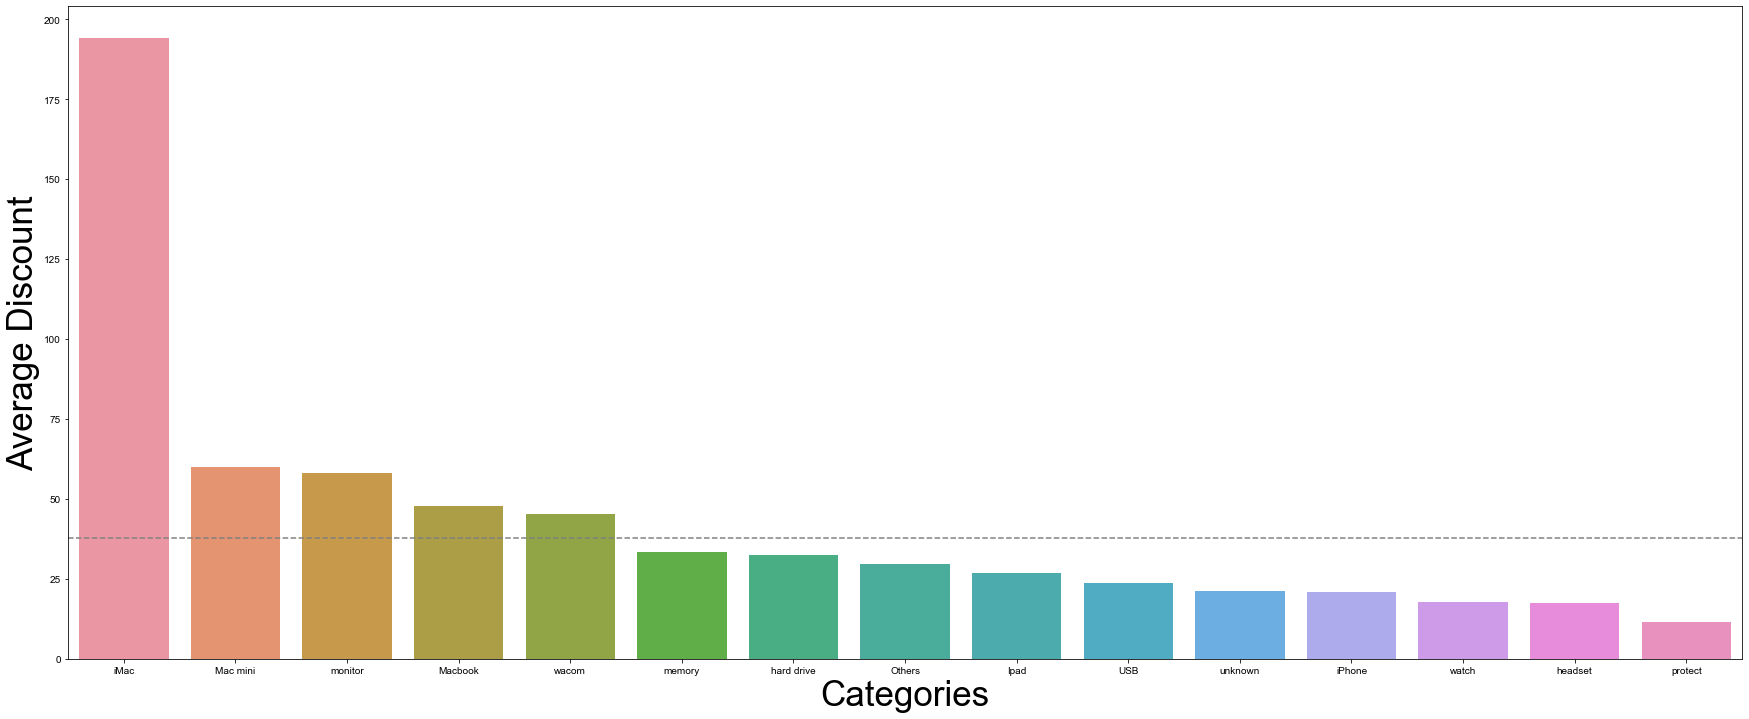

In [10]:
plt.subplots(figsize=(30, 12))

p = sns.barplot(data=e, x='category', y='disc')

p.axhline(p_df1['disc'].mean(), linestyle='--', color='gray')

plt.xlabel('Categories', fontsize=35)
plt.ylabel('Average Discount', fontsize=35)
#plt.title('Average Discount by Categories', fontsize=45)
sns.set_style('dark')
sns.set_context('talk', font_scale=1.5)




plt.show()

##### Plot: Total price vs categories

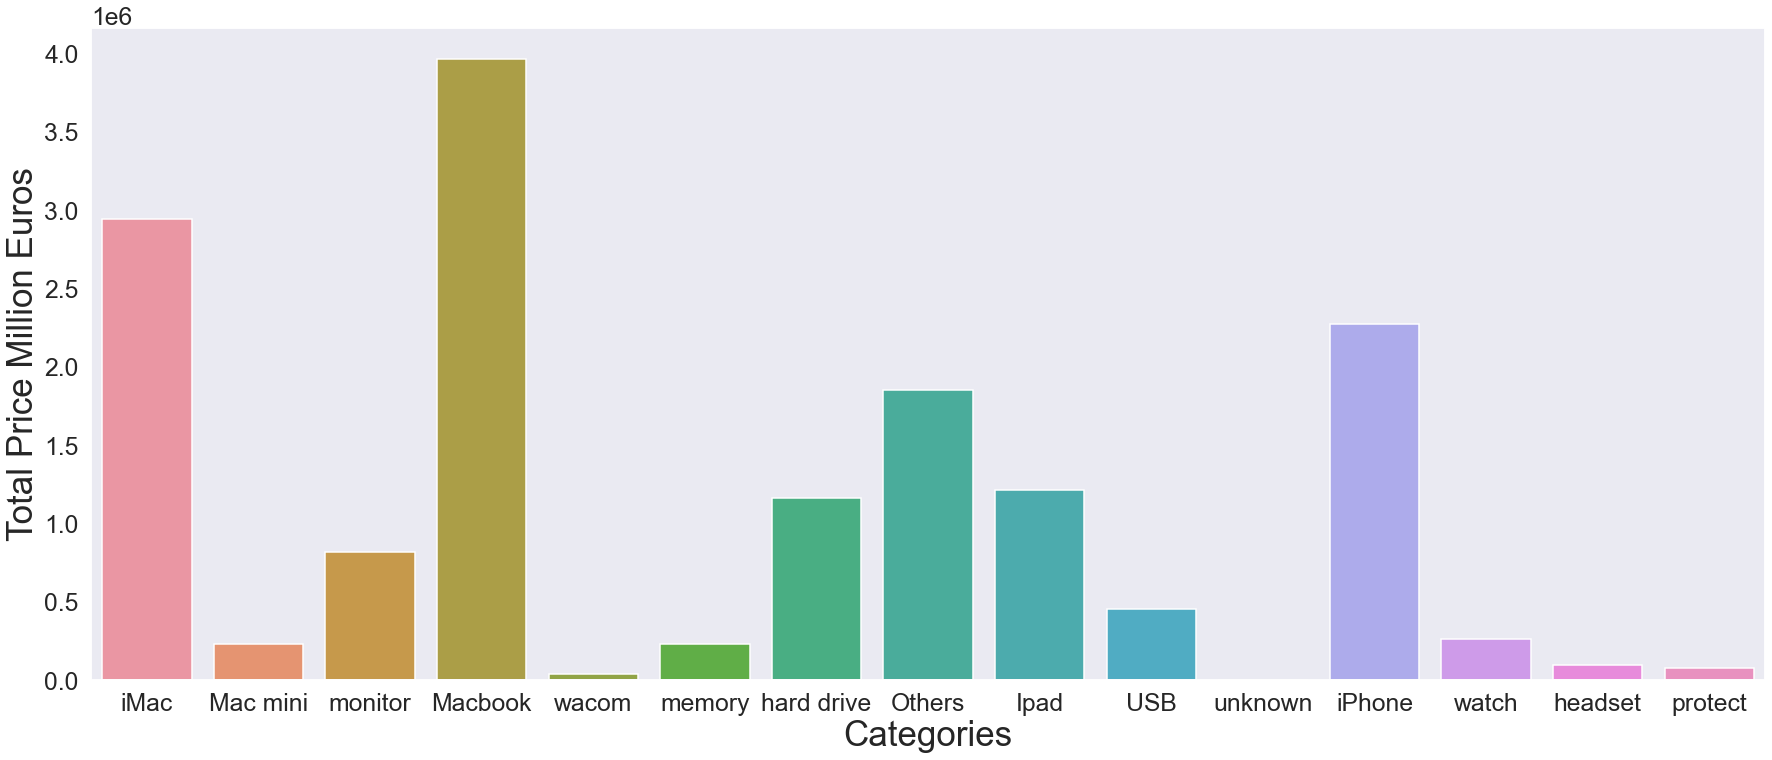

In [11]:
plt.subplots(figsize=(30, 12))

sns.barplot(data=e, x='category', y='total_price')
plt.xlabel('Categories', fontsize=35)
plt.ylabel('Total Price Million Euros', fontsize=35)
#plt.title('Total Price by Categories', fontsize=45)
sns.set_style('dark')
sns.set_context('talk', font_scale=1.5)
plt.show()

##### New dfs to relate the prices and discounts to the order states

In [12]:
p_df2 = (
orderlines
    .merge(orders, how='left', left_on='id_order', right_on='order_id')
    #.query('state == "Completed"')
    .merge(products, how='left')
    .assign(price = lambda x: np.where(np.isnan(x['price']), x['max_price_orderlines'], x['price']))
    .assign(disc = lambda x: x['price'] - x['unit_price'],
           disc_perc = lambda x: round((1 - x['unit_price'] / x['price'])*100), 
           year_month = lambda x: x['date'].dt.to_period('M')))

In [13]:
sta = p_df2.groupby('state').agg({'disc':['mean', 'median', 'sum'], 'total_price':'sum', 'product_quantity':'sum'}).reset_index()

In [14]:
sta2 = p_df2.groupby(['state', 'year_month'])['disc'].mean().reset_index()

##### Plot: Average discount vs months in relation to states

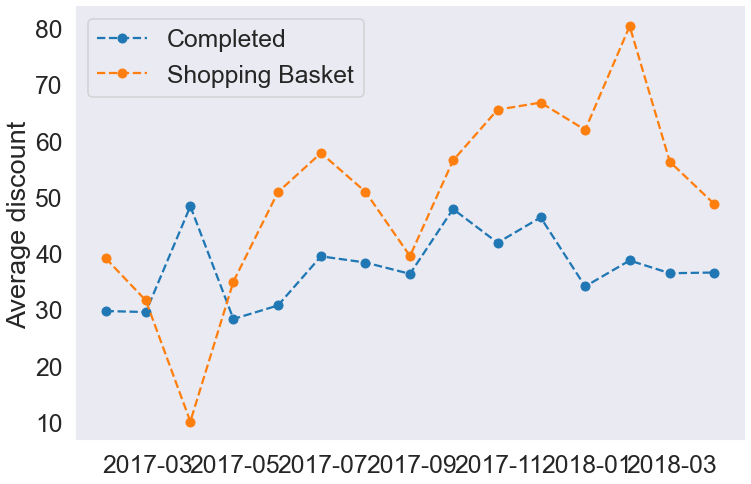

In [19]:
f, ax = plt.subplots(figsize=(12, 8))

#plt.plot_date(data=sta2.query('state == "Cancelled"'), x='year_month', y='disc', linestyle='--', label='Cancelled')
plt.plot_date(data=sta2.query('state == "Completed"'), x='year_month', y='disc', linestyle='--', label='Completed')
#plt.plot_date(data=sta2.query('state == "Pending"'), x='year_month', y='disc', linestyle='--', label='Pending')
#plt.plot_date(data=sta2.query('state == "Place Order"'), x='year_month', y='disc', linestyle='--', label='Place Order')
plt.plot_date(data=sta2.query('state == "Shopping Basket"'), x='year_month', y='disc', linestyle='--', label='Shopping Basket')
ax.legend()

#plt.title('Evolution of discounts % overtime')
plt.ylabel('Average discount')
sns.despine()
plt.show()

##### Plot: Total price vs months in relation to states

In [17]:
sta3 = p_df2.groupby(['state', 'year_month'])['total_price'].sum().reset_index()

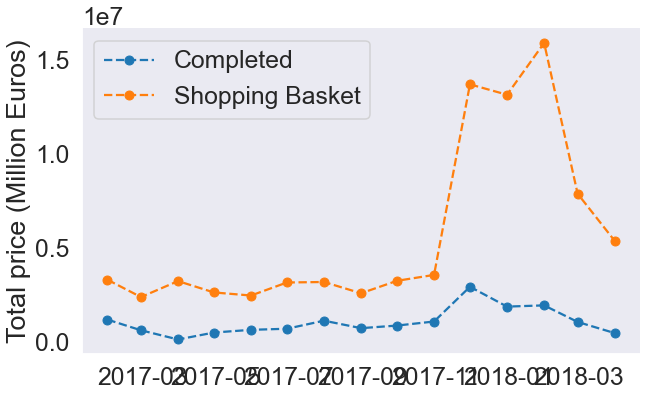

In [18]:
f, ax = plt.subplots(figsize=(10, 6))

#plt.plot_date(data=sta3.query('state == "Cancelled"'), x='year_month', y='total_price', linestyle='--', label='Cancelled')
plt.plot_date(data=sta3.query('state == "Completed"'), x='year_month', y='total_price', linestyle='--', label='Completed')
#plt.plot_date(data=sta3.query('state == "Pending"'), x='year_month', y='total_price', linestyle='--', label='Pending')
#plt.plot_date(data=sta3.query('state == "Place Order"'), x='year_month', y='total_price', linestyle='--', label='Place Order')
plt.plot_date(data=sta3.query('state == "Shopping Basket"'), x='year_month', y='total_price', linestyle='--', label='Shopping Basket')
ax.legend()

#plt.title('Evolution of total_price overtime')
plt.ylabel('Total price (Million Euros)')
sns.despine()
plt.show()

### Part 2: Revenue and discount over time

##### Create df for to show relation of revenue over time

In [21]:
revenue_per_month = (
orderlines
    .merge(orders, how='right', left_on='id_order', right_on='order_id')
    .query('state == "Completed"')
    .assign(year = lambda x: x['date'].dt.strftime('%Y'), 
            month = lambda x: x['date'].dt.strftime('%m'))
    .query('year == "2017"')
    .assign(add_costs = lambda x: x['total_paid'] - x['total_price'])
    .groupby(['month'])
    .agg({'total_paid':'mean'})
    .reset_index()
)

##### Calculate average discount over time

In [23]:
discount_per_month = (
orderlines
    .merge(orders, how='left', left_on='id_order', right_on='order_id')
    .query('state == "Completed"')
    .merge(products, how='left')
    .assign(price = lambda x: np.where(np.isnan(x['price']), x['max_price_orderlines'], x['price']))
    .assign(discount = lambda x: x['price'] - x['unit_price'], 
            disc_percnt = lambda x: round((1 - x['unit_price'] / x['price'])*100))
    .assign(year = lambda x: x['date'].dt.strftime('%Y'), 
            month = lambda x: x['date'].dt.strftime('%m'))
    .groupby(['month'])
    .agg({'disc_percnt':'mean'})
    .reset_index()
)

##### Calculate sales volumes over time

In [22]:
sales_per_month = (
orders
    .query('state == "Completed"')
    .assign(year = lambda x: x['created_date'].dt.strftime('%Y'), 
            month = lambda x: x['created_date'].dt.strftime('%m'))
    .query('year == "2017"')
    .groupby(['month'])
    .agg({'order_id':'count'})
    .reset_index()
)

##### Plot: Average revenues vs average discounts

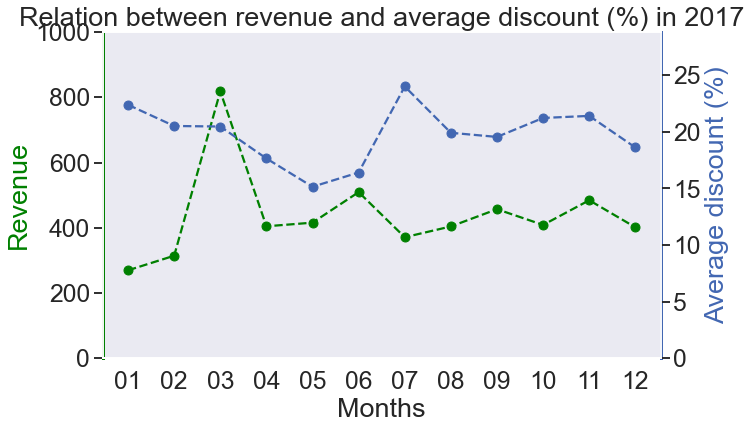

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

# plot 1 (revenue)
ax.plot_date(data=revenue_per_month, x='month', y='total_paid', linestyle='--', color='green')
ax.set_ylabel("Revenue").set_color('green')
ax.set_xlabel('Months')
ax.get_ylim()
ax.set_ylim(0, 1000)
# we specify in matplotlib you have to add a second y axis
ax2 = plt.twinx()
# plot 2 (discounts)
ax2.plot_date(data=discount_per_month, x='month', y='disc_percnt', linestyle='--', color='#4267B2')
ax2.set_ylabel('Average discount (%)').set_color('#4267B2')
ax2.set_ylim(0, 1)
# plot info
plt.ylim(0, discount_per_month['disc_percnt'].max()*1.2)
plt.xlabel('Months')
plt.title('Relation between revenue and average discount (%) in 2017')
ax.spines['left'].set_color('green')
ax.spines['right'].set_color('#4267B2')
ax.spines['right'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
plt.show()

##### Plot: Sales volumes vs Discounts

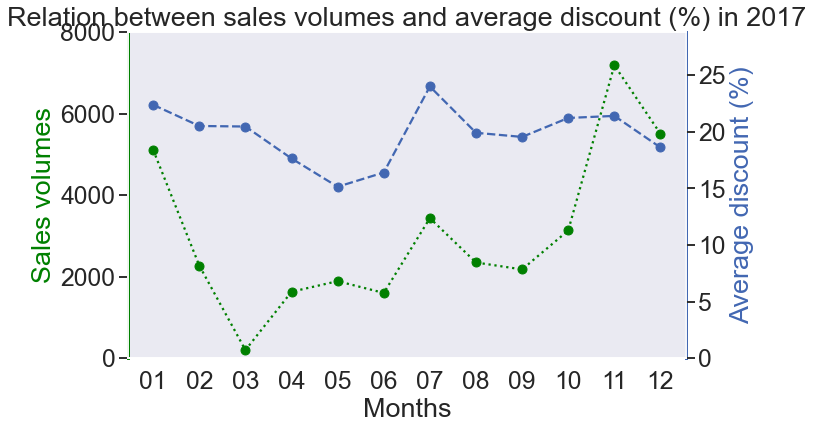

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

# plot 1 (sales)
ax.plot_date(data=sales_per_month, x='month', y='order_id', linestyle=':', color='green')
ax.set_ylabel("Sales volumes").set_color('green')
ax.set_xlabel('Months')
ax.get_ylim()
ax.set_ylim(0, 8000)
# we specify in matplotlib you have to add a second y axis
ax2 = plt.twinx()
# plot 2 (discounts)
ax2.plot_date(data=discount_per_month, x='month', y='disc_percnt', linestyle='--', color='#4267B2')
ax2.set_ylabel('Average discount (%)').set_color('#4267B2')
ax2.set_ylim(0, 1)
# plot info
plt.ylim(0, discount_per_month['disc_percnt'].max()*1.2)
plt.xlabel('Months')
plt.title('Relation between sales volumes and average discount (%) in 2017')
ax.spines['left'].set_color('green')
ax.spines['right'].set_color('#4267B2')
ax.spines['right'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
plt.show()

### Part 3: 

##### Create orderlines-df with state = completed

In [26]:
orders_compl = orders.query('state == "Completed"')
orderlines = orderlines.drop(columns={'product_id', 'check_orders'})
orderlines_compl = orderlines.loc[orderlines['id_order'].isin(orders_compl['order_id'])].reset_index().copy()
orderlines_compl = orderlines_compl.drop(columns={'index', 'id'})

##### List of products sold more than 20000 times

In [27]:
prod_sold_over_20000_times = (
orderlines_compl
    .groupby(['sku'])
    .agg({'id_order':'count', 'product_quantity':'sum'})
    .reset_index()
    .assign(sold_sku = lambda x: round(x['id_order']*x['product_quantity']))
    .sort_values('sold_sku', ascending=False)
    .reset_index()
    .drop(columns={'index'})
    .head(41)
)

##### Add the name, brand, revenue, discount to the list

In [28]:
ol_compl_with_sku_from_pso20000 = (
orderlines_compl
    .merge(prod_sold_over_20000_times, how='right', left_on='sku', right_on='sku')
    .merge(products, how='inner', left_on='sku', right_on='sku')
    .assign(short = lambda x: x['sku'].str[:3])
    .merge(brands, how='left', left_on='short', right_on='short')
    .rename(columns={'long':'brand'})
    .filter(['sku', 'total_price', 'price', 'sold_sku', 'unit_price', 'name', 'brand'])
)

In [29]:
ol_compl_with_sku_from_pso20000_disc = (
ol_compl_with_sku_from_pso20000
    .groupby(['sku', 'sold_sku', 'name', 'brand'])
    .agg({'total_price': 'mean', 'price':'mean', 'unit_price':'mean'})
    .assign(disc_perc = lambda x: round((1 - x['unit_price'] / x['price'])*100))
    .sort_values('sold_sku', ascending=False)
    .dropna()
    .reset_index()
)

In [32]:
ol_compl_with_sku_from_pso20000_dis_total = (
ol_compl_with_sku_from_pso20000_disc
    .assign(total_per_sku_mil = lambda x: round((x['sold_sku']*x['total_price']/1000000),2))
    .assign(sold_sku_k = lambda x: round(x['sold_sku']/1000))
)
ol_compl_with_sku_from_pso20000_dis_total['sold_sku_k_int'] = ol_compl_with_sku_from_pso20000_dis_total['sold_sku_k'].astype('int32')

##### Plot: Discount vs sales numbers

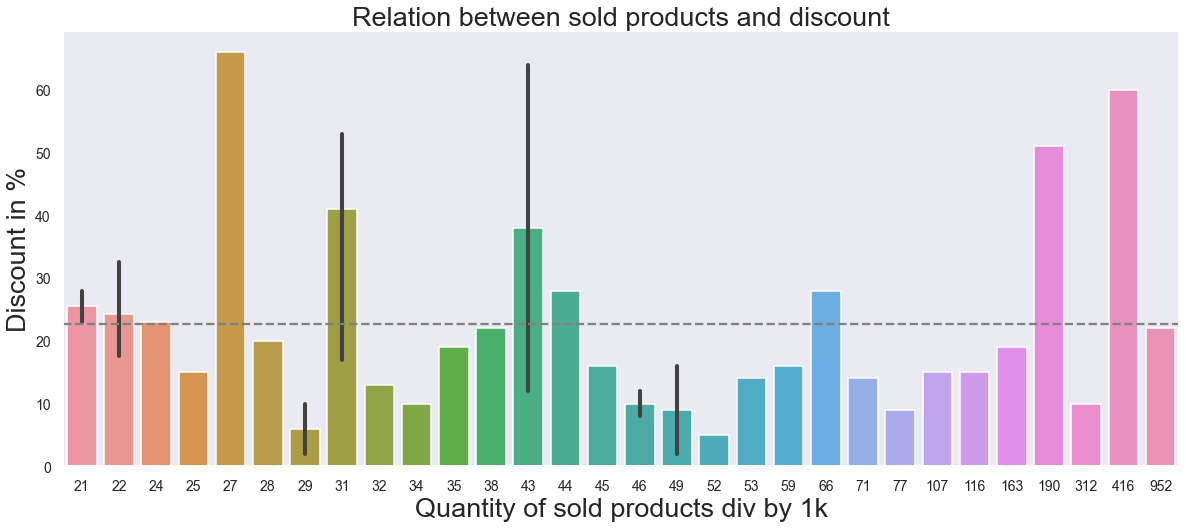

In [33]:
plt.subplots(figsize=(20, 8))


p = sns.barplot(
    data=ol_compl_with_sku_from_pso20000_dis_total,
    x='sold_sku_k_int',
    y='disc_perc')

p.axhline(
    ol_compl_with_sku_from_pso20000_dis_total['disc_perc'].mean(),
    linestyle='--',
    color='gray')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Quantity of sold products div by 1k')
plt.ylabel('Discount in %')
plt.title('Relation between sold products and discount')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

##### Plot: Discount vs price in relation to sales numbers

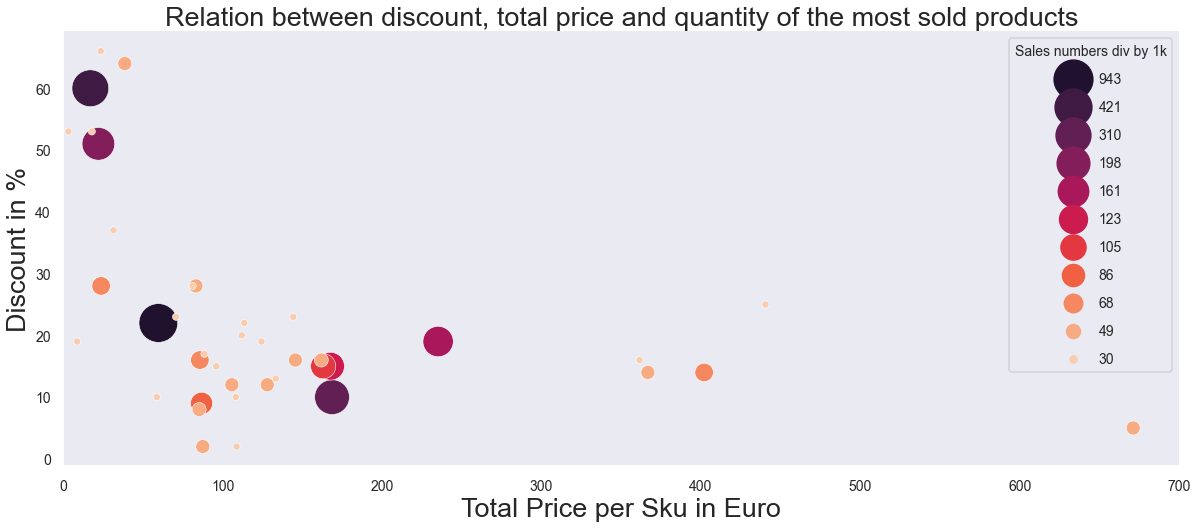

In [34]:
p_df = (
ol_compl_with_sku_from_pso20000_dis_total
    .assign(sold_sku_k_cat = lambda x: pd.cut(x['sold_sku_k_int'], bins=50))
    .assign(min_bin = lambda x: x['sold_sku_k_cat'])
)
p_df = (
p_df
    .assign(left_interval = [cat.left for cat in p_df['sold_sku_k_cat']], 
            right_interval = [cat.right for cat in p_df['sold_sku_k_cat']])
    .assign(mean_interval = lambda x: x[['left_interval','right_interval']].mean(axis=1))
    .assign(mean_interval_cat = lambda x: (round(x['mean_interval'],0).astype('int')).astype('str'))
)
p_df['mean_interval'].unique()

plt.subplots(figsize=(20, 8))

sc = sns.scatterplot(
    data=p_df, 
    x='total_price', y='disc_perc', 
    hue='mean_interval_cat', 
    size='mean_interval_cat',
    sizes=(50, 1500),
    palette="rocket") #'ch:start=.2,rot=-.3'

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Total Price per Sku in Euro')
plt.ylabel('Discount in %')
plt.title('Relation between discount, total price and quantity of the most sold products')
plt.legend(handlelength=2, labelspacing=1, prop={'size': 14}, 
           loc="upper right", numpoints=5, title_fontsize=14, 
           title = 'Sales numbers div by 1k')
plt.xlim(0, 700)
sns.despine()
plt.show()


##### Plot: Discount vs revenue in relation to sales numbers

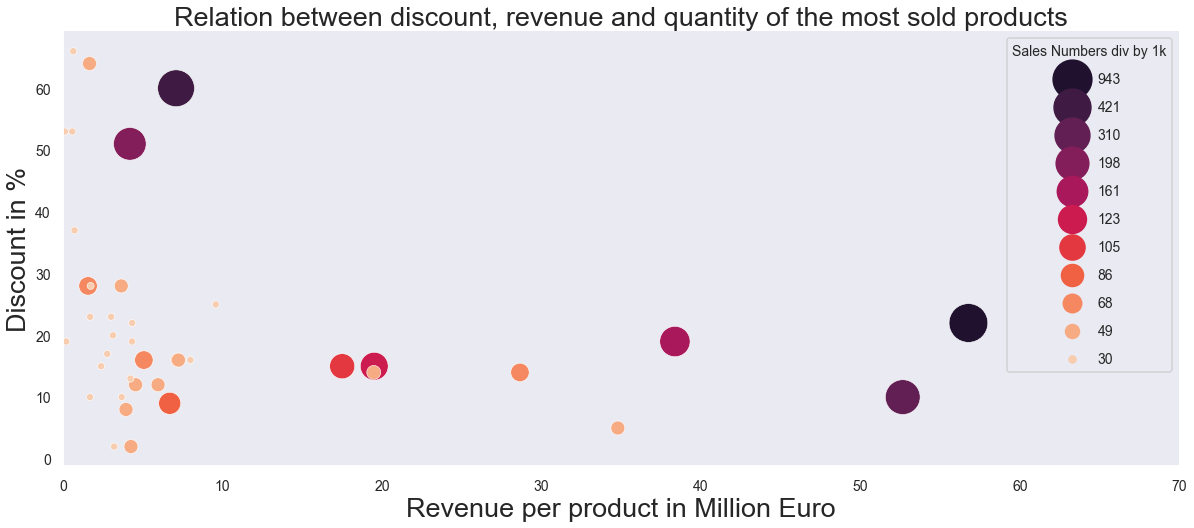

In [35]:
p_df = (
ol_compl_with_sku_from_pso20000_dis_total
    .assign(sold_sku_k_cat = lambda x: pd.cut(x['sold_sku_k_int'], bins=50))
    .assign(min_bin = lambda x: x['sold_sku_k_cat'])
)
p_df = (
p_df
    .assign(left_interval = [cat.left for cat in p_df['sold_sku_k_cat']], 
            right_interval = [cat.right for cat in p_df['sold_sku_k_cat']])
    .assign(mean_interval = lambda x: x[['left_interval','right_interval']].mean(axis=1))
    .assign(mean_interval_cat = lambda x: (round(x['mean_interval'],0).astype('int')).astype('str'))
)
p_df['mean_interval'].unique()

plt.subplots(figsize=(20, 8))

sc = sns.scatterplot(
    data=p_df, 
    x='total_per_sku_mil', y='disc_perc', 
    hue='mean_interval_cat', 
    size='mean_interval_cat',
    sizes=(50, 1500),
    palette="rocket") #'ch:start=.2,rot=-.3'

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Revenue per product in Million Euro')
plt.ylabel('Discount in %')
plt.title('Relation between discount, revenue and quantity of the most sold products')
plt.legend(handlelength=2, labelspacing=1, prop={'size': 14}, 
           loc="upper right", numpoints=5, title_fontsize=14, 
           title = 'Sales Numbers div by 1k')
plt.xlim(0, 70)
sns.despine()
plt.show()
